In [5]:
import os
import cv2
import math
import random
from typing import List
from collections import Counter
import detectron2
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer
from script.read_eo_dataset import read_eo_dataset
from utils.annotation.annotation_interfaces import DetectionAnnotations
import numpy as np

In [6]:
def collect_class_info(anno):
    objs = sum([FILE.OBJECTS for FILE in anno.FILES], [])
    classes_info = Counter([obj.CLASS for obj in objs])
    classes_list = list(classes_info.keys())

    return classes_list


def bbox_convert(xmin: float,
                 ymin: float,
                 xmax: float,
                 ymax: float,
                 theta: float) -> List:

    bbox_width = xmax - xmin
    bbox_height = ymax - ymin

    center_x = xmin + (bbox_width / 2)
    center_y = ymin + (bbox_height / 2)

    return [center_x, center_y, bbox_width, bbox_height, math.degrees(theta)]


def get_eo_detection_dicts():
    annotations = read_eo_dataset()
    detection_anno = DetectionAnnotations(annotations)
    classes_list = collect_class_info(detection_anno)

    dataset_dicts = []
    for idx, FILE in enumerate(detection_anno.FILES):
        record = {}

        filename = FILE.FILEPATH
        height = FILE.IMAGE_HEIGHT
        width = FILE.IMAGE_WIDTH

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []

        for OBJ in FILE.OBJECTS:
            xmin = OBJ.XMIN
            ymin = OBJ.YMIN
            xmax = OBJ.XMAX
            ymax = OBJ.YMAX
            theta = -OBJ.THETA

            classes = OBJ.CLASS

            cx, cy, bbox_w, bbox_h, angle = bbox_convert(xmin, ymin, xmax, ymax, theta)
            objs.append({"bbox": [cx, cy, bbox_w, bbox_h, angle],
                         "bbox_mode": BoxMode.XYWHA_ABS,
                         "category_id": classes_list.index(classes),
                         "iscrowd": 0})

            record["annotations"] = objs

        dataset_dicts.append(record)

    return dataset_dicts

def dataset_visualization(dataset_dicts, display: bool=True):
    import matplotlib.pyplot as plt

    if not display:
        return

    for d in random.sample(dataset_dicts, 3):
        img = cv2.imread(d["file_name"])
        visualizer = Visualizer(img[:, :, ::-1], metadata=eo_detection_metadata, scale=1)

        vis = visualizer.draw_dataset_dict(d)
        
        print(vis)
        test_img = vis.get_image()[:, :, ::-1]

        plt.figure()
        plt.imshow(test_img)
        plt.show()

        
from detectron2.structures import (
    BoxMode
)

def instance_to_annotations(instance):
    bboxes, classes = instance.gt_boxes.tensor.numpy(), instance.gt_classes.numpy()
    annotations = []
    for box, c in zip(bboxes, classes):
        annotations.append(
            {'bbox': box, 'bbox_mode':BoxMode.XYWHA_ABS , 'category_id': c, 'iscrowd': 0}
        )
    return annotations
    
        
## data-augmentation visualization
def transform_visualization(dataset_dict, display: bool=True):
    import matplotlib.pyplot as plt
    if not display:
        return
    
    dataset_dict['annotations'] = instance_to_annotations(dataset_dict['instances'])
    img = np.transpose(dataset_dict['image'].detach().numpy(), (1, 2, 0))
    visualizer = Visualizer(img[:, :, ::-1], metadata=eo_detection_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(dataset_dict)
    test_img = vis.get_image()[:, :, ::-1]
    plt.figure()
    plt.imshow(test_img)
    plt.show()

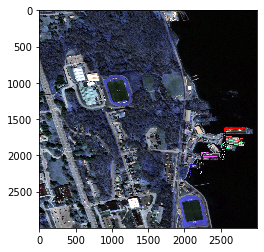

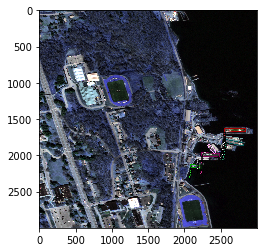

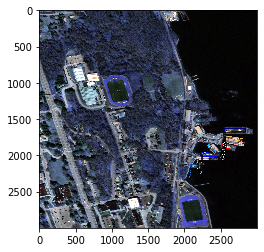

In [7]:
DatasetCatalog.register("EO-Detection", get_eo_detection_dicts)
MetadataCatalog.get("EO-Detection").set(thing_classes=["maritime vessels",
                                                       "container",
                                                       "oil tanker",
                                                       "aircraft carrier"])
eo_detection_metadata = MetadataCatalog.get("EO-Detection")

dataset_dicts = get_eo_detection_dicts()
dataset_visualization(dataset_dicts=dataset_dicts[:1] * 3, display=True)

## Config

In [8]:
from detectron2 import model_zoo
cfg = get_cfg()

# Model Archtiecture

cfg.merge_from_file(detectron2.model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))

# 변경 내용
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_BOX_HEAD.NAME = "FastRCNNConvFCHead"
cfg.MODEL.ROI_BOX_HEAD.NUM_FC = 2
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (1, 1, 1, 1, 1)
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (10, 10, 5, 5, 1)

cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[0, 45, 90, 135, 180]]


# 추가
cfg.MODEL.MASK_ON = False
cfg.MODEL.KEYPOINT_ON = False

# 원탁님 코드
#cfg.MODEL.BACKBONE.NAME = "build_resnet_fpn_backbone"
#cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
#cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
#cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[0, 45, 90, 135, 180]]
#cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
#cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"

cfg.DATASETS.TRAIN = ("EO-Detection",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 1

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.BASE_LR = 0.00025

# Cutout

In [19]:
import torchvision


def apply_mask(image, mask):
    mask = np.concatenate([np.expand_dims(mask, - 1)] * 3, axis=-1)
    mask = np.int32(mask)
    return image * mask


def cutout(n_mask, size, length, p):
    '''
    n_mask: the number of mask per section, int
    size: the size of section, int
    length: length of mask. Int.
    p: probability of mask, Float.
    
    Return
        _cutout: Function for cutout
    '''
    def _cutout(image):
        h, w, _ = image.shape
        mask = np.ones((h, w), np.float32)
        for sh in range(h // size):
            for sw in range(w // size):
                for _ in range(n_mask):
                    if np.random.random() > p:
                        continue
                    y = np.random.randint(sh * size, (sh + 1) * size)
                    x = np.random.randint(sw * size, (sw + 1) * size)
                    y1 = np.clip(y - length // 2, 0, h)
                    y2 = np.clip(y + length // 2, 0, h)
                    x1 = np.clip(x - length // 2, 0, w)
                    x2 = np.clip(x + length // 2, 0, w)
                    mask[y1:y2, x1:x2] = 0.
        mask = np.concatenate([np.expand_dims(mask, - 1)] * 3, axis=-1)
        mask = np.int32(mask)
        return image * mask
    return _cutout

cutout_trf = torchvision.transforms.Compose([
    cutout(100, 200, 10, 0.9)
])

## Custom dataloader

In [24]:
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode
import copy
import torch


In [25]:
# custome ransform_instance_annotations for Rotated bbox
def transform_instance_annotations(
    annotation, transforms, image_size
):
    bbox = np.asarray([annotation['bbox']])
    annotation["bbox"] = transforms.apply_rotated_box(bbox)[0]
    annotation["bbox_mode"] = BoxMode.XYWHA_ABS
    return annotation

In [26]:
class CDatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is the default callable to be used to map your dataset dict into training data.
    You may need to follow it to implement your own one for customized logic.

    The callable currently does the following:

    1. Read the image from "file_name"
    2. Applies cropping/geometric transforms to the image and annotations
    3. Prepare data and annotations to Tensor and :class:`Instances`
    """

    def __init__(self, cfg, is_train=True):


        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        utils.check_image_size(dataset_dict, image)

        image, transforms = T.apply_transform_gens(self.tfm_gens, image)
        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        
        if self.is_train:
            image = cutout_trf(image)
        
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))
    
    

            

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            annos = [
                transform_instance_annotations(
                    obj, transforms, image_shape
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            
            
            instances = utils.annotations_to_instances_rotated(
                annos, image_shape
            )
            
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict


## Visualize data augmentation

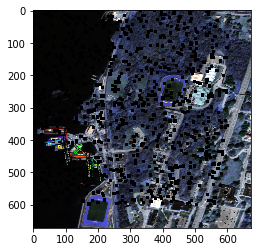

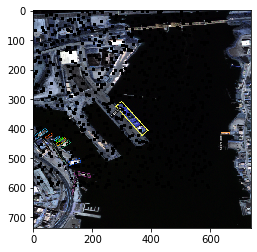

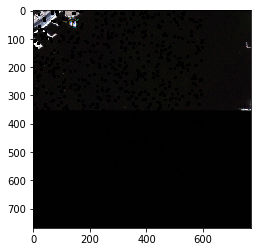

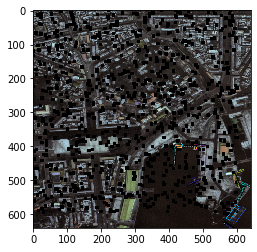

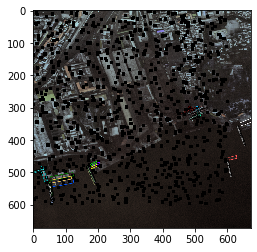

In [27]:
from detectron2.data import build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.structures import BoxMode

dataloader = build_detection_train_loader(cfg, CDatasetMapper(cfg, True))

for i in range(5):
    data = dataloader.dataset.dataset.__getitem__(i)
    transform_visualization(data)

## Run

In [28]:
from detectron2.engine import DefaultTrainer


class Trainer(DefaultTrainer):
    
    def __init__(self, cfg):
        super(Trainer, self).__init__(cfg)
    
    @classmethod
    def build_test_loader(cls, cfg):
        print('# custome test loader!!')
        return build_detection_test_loader(cfg, CDatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        print('# custome train loader!!')
        return build_detection_train_loader(cfg, CDatasetMapper(cfg, True))

In [29]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[02/12 11:46:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# custome train loader!!
[02/12 11:46:09 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/12 11:46:14 d2.data.build]: Removed 0 images with no usable annotations. 1593 images left.
[02/12 11:46:15 d2.data.build]: Using training sampler TrainingSampler


'proposal_generator.anchor_generator.cell_anchors.0' has shape (3, 4) in the checkpoint but (15, 5) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.1' has shape (3, 4) in the checkpoint but (15, 5) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.2' has shape (3, 4) in the checkpoint but (15, 5) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.3' has shape (3, 4) in the checkpoint but (15, 5) in the model! Skipped.
'proposal_generator.anchor_generator.cell_anchors.4' has shape (3, 4) in the checkpoint but (15, 5) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.weight' has shape (3, 256, 1, 1) in the checkpoint but (15, 256, 1, 1) in the model! Skipped.
'proposal_generator.rpn_head.objectness_logits.bias' has shape (3,) in the checkpoint but (15,) in the model! Skipped.
'proposal_generator.rpn_head.anchor_deltas.weight' has shape (12, 256, 1, 1) in the checkpoint but (75, 256, 1, 1) in the mod

[02/12 11:46:15 d2.engine.train_loop]: Starting training from iteration 0
[02/12 11:46:23 d2.utils.events]: eta: 8:15:24  iter: 19  total_loss: 1.541  loss_cls: 0.088  loss_box_reg: 0.001  loss_rpn_cls: 0.735  loss_rpn_loc: 0.560  time: 0.3490  data_time: 0.0935  lr: 0.000005  max_mem: 1561M
[02/12 11:46:30 d2.utils.events]: eta: 8:11:42  iter: 39  total_loss: 1.452  loss_cls: 0.052  loss_box_reg: 0.000  loss_rpn_cls: 0.734  loss_rpn_loc: 0.619  time: 0.3373  data_time: 0.0058  lr: 0.000010  max_mem: 2055M
[02/12 11:46:36 d2.utils.events]: eta: 8:04:25  iter: 59  total_loss: 0.965  loss_cls: 0.071  loss_box_reg: 0.000  loss_rpn_cls: 0.730  loss_rpn_loc: 0.154  time: 0.3283  data_time: 0.0050  lr: 0.000015  max_mem: 2055M
[02/12 11:46:42 d2.utils.events]: eta: 8:02:53  iter: 79  total_loss: 0.949  loss_cls: 0.043  loss_box_reg: 0.000  loss_rpn_cls: 0.708  loss_rpn_loc: 0.220  time: 0.3266  data_time: 0.0055  lr: 0.000020  max_mem: 2055M
[02/12 11:46:49 d2.utils.events]: eta: 8:02:15  it

[02/12 11:50:16 d2.utils.events]: eta: 7:59:15  iter: 739  total_loss: 0.468  loss_cls: 0.052  loss_box_reg: 0.000  loss_rpn_cls: 0.219  loss_rpn_loc: 0.161  time: 0.3232  data_time: 0.0051  lr: 0.000185  max_mem: 3453M
[02/12 11:50:23 d2.utils.events]: eta: 7:58:33  iter: 759  total_loss: 0.661  loss_cls: 0.035  loss_box_reg: 0.000  loss_rpn_cls: 0.268  loss_rpn_loc: 0.381  time: 0.3230  data_time: 0.0052  lr: 0.000190  max_mem: 3453M
[02/12 11:50:29 d2.utils.events]: eta: 7:58:26  iter: 779  total_loss: 0.951  loss_cls: 0.064  loss_box_reg: 0.012  loss_rpn_cls: 0.306  loss_rpn_loc: 0.503  time: 0.3228  data_time: 0.0054  lr: 0.000195  max_mem: 3453M
[02/12 11:50:35 d2.utils.events]: eta: 7:58:20  iter: 799  total_loss: 1.151  loss_cls: 0.082  loss_box_reg: 0.002  loss_rpn_cls: 0.387  loss_rpn_loc: 0.654  time: 0.3227  data_time: 0.0052  lr: 0.000200  max_mem: 3453M
[02/12 11:50:42 d2.utils.events]: eta: 7:57:56  iter: 819  total_loss: 1.416  loss_cls: 0.068  loss_box_reg: 0.001  loss

KeyboardInterrupt: 